In [95]:
%config Completer.use_jedi = False

In [52]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mne
import json
import scipy.stats
import scipy.signal as sig

# import scipy.io as sio
# from scipy import signal

import pac

import simple_pipeline


suffix = '_1_50'#'_1ch_nv'
gamma = [10, 80]
beta  = [ 1, 16]

filt_wind = np.ones((3, 3))
filt_wind /= filt_wind.sum()

# functions

In [2]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
linestyles = ['-', ':', '--']

groups = ['PD Med Off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']

In [3]:
def plot_pac(pac, high_freq=gamma, low_freq=beta, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((pac), origin='lower', interpolation='spline36', #'nearest', 
                   extent=low_freq+high_freq,
#                    aspect='auto', )
                   aspect=np.diff(low_freq)/np.diff(high_freq), **kwargs)

    if ax is None:
        plt.show()
        
    return im

In [4]:
def get_percent(arr, thr=0.95):
    if arr.ndim > 1:
        arr = arr.ravel()
    freq, bins = np.histogram(arr, bins=100)
    return (
        bins[:-1][(freq / freq.sum()).cumsum() > thr][0], 
        bins[1:][(freq / freq.sum()).cumsum() > thr][0]
    )

In [5]:
def save_fig(path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(path)

# Create Task list in `tasks_df`

In [6]:
if __name__ == '__main__':
    tasks_df = simple_pipeline.create_tasks_df()
    
    completed = []
    for task in tasks_df.iloc:
        json_path = os.path.join(task['dir'], task['file_formatter'].format(f'completed{suffix}.json'))
        completed.append(os.path.exists(json_path))

    tasks_df = pd.concat([tasks_df, pd.DataFrame({'completed': completed})], axis=1)

In [7]:
os.path.join(task['dir'], task['file_formatter'].format(f'mvls{suffix}.npz'))

'/home/kiani/DS/ds003490-download/sub-050/ses-01/eeg/sub-050_ses-01_task-Rest_mvls_1_50.npz'

# Load Data

In [ ]:
# MVL

mvl_2ds_time = [[] for k in groups] # np.zeros((3, 64, 169, 37 * 12))
mvl_2ds = [[] for k in groups] # np.zeros((3, 64, 61, 13 )//169, 37))
mvls = [[] for k in groups] # np.zeros((3, 64))

for task in tasks_df.iloc:
# if 1:
    task_mvls = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'mvls{suffix}.npz')))
    task_mvl_2ds = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'mvl_2ds{suffix}.npz')))
    
    # mvls
    nbchan = task_mvls[task_mvls.files[0]].shape[0]
    mvl = np.zeros((3, nbchan))
    for i, event_type in enumerate(sorted(task_mvls.files)):
        mvl[i] = task_mvls[event_type].diagonal()
        
    mvls[task.pd_drug_type].append(mvl)
    
    # mvl_2ds
    mvl_2d = np.zeros((3, nbchan, gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1))
    for i, event_type in enumerate(sorted(task_mvl_2ds.files)):
        mvl_2d[i] = task_mvl_2ds[event_type].diagonal(0, 0, 1).transpose((2, 0, 1))
        
    mvl_2ds[task.pd_drug_type].append(mvl_2d)

mvls = np.array(mvls)              # --> (pd_drug_type, subjects, event_types, channels)
mvl_2ds = np.array(mvl_2ds)        # --> (pd_drug_type, subjects, event_types, channels, high_freqs, low_freqs)
mvl_2ds_time = np.array(mvl_2ds_time)        # --> (pd_drug_type, subjects, event_types, channels, high_freqs, low_freqs * 12)

In [9]:
# ERP

epochs = [[] for k in groups] # np.zeros((2, 63, 601))

for task in tasks_df.iloc:
    task_epochs = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'epochs.npz')))
    
    # epochs
    nbchan = task_epochs[task_epochs.files[0]].shape[-2]
    nbtime = task_epochs[task_epochs.files[0]].shape[-1]
    epoch = np.zeros((3, 2, nbchan, nbtime))
    for i, event_type in enumerate(sorted(task_epochs.files)):
        epoch[i, 0] = task_epochs[event_type].mean(axis=0)
        epoch[i, 1] = task_epochs[event_type].std(axis=0)
        
    epochs[task.pd_drug_type].append(epoch)

epochs = np.array(epochs)          # --> (pd_drug_type, subjects, event_types, (mean, std), channels, time)

# Plot ERP

In [ ]:
# Plot for subjects

for ch in range(epochs.shape[4]):
    print(ch)
    for drug_type in range(epochs.shape[0]):

        ymin = (epochs[:, :, :, 0, ch, :] - epochs[:, :, :, 1, ch, :]).min()
        ymax = (epochs[:, :, :, 0, ch, :] + epochs[:, :, :, 1, ch, :]).max()

        for sub in range(epochs.shape[1]):
#             fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 15))
            plt.figure(figsize=(15, 7))
            
            for event_type in range(epochs.shape[2]):    
                erp = epochs[drug_type, sub, event_type, :, ch, :][0]
                std = epochs[drug_type, sub, event_type, :, ch, :][1]
                plt.plot(np.linspace(-200, 1000, 601), (erp), linewidth=2, color=colors[event_type], label=event_types[event_type])
                plt.plot(np.linspace(-200, 1000, 601), (erp + std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
                plt.plot(np.linspace(-200, 1000, 601), (erp - std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
                
            plt.grid()
            plt.ylim(ymin, ymax)
            plt.xlim(-200, 1000)
            gca = plt.gca()
            plt.plot([0, 0], [ymin, ymax], color='#999999', linestyle='--')
            plt.plot([100, 100], [ymin, ymax], color='#999999', linestyle='--')
            plt.plot([250, 250], [ymin, ymax], color='#999999', linestyle='--')
            plt.sca(gca)
            plt.title(f'Sub {sub + 1}, {groups[drug_type]}, Channel {channels[ch]}')
            plt.legend()
            
            
            if not os.path.exists(os.path.join('plots', f'erps', f'Sub{sub + 1}')):
                os.makedirs(os.path.join('plots', f'erps', f'Sub{sub + 1}'))
            plt.savefig(os.path.join('plots', 'erps', f'Sub{sub + 1}',
                                     f'Sub{sub + 1}_{groups[drug_type]}_{channels[ch]}.png'))
            plt.close()
#           plt.show()
            
#             break
#         break
#     break
    

In [11]:
# Plot events

for ch in range(epochs.shape[4]):
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 15))
    for drug_type in range(epochs.shape[0]):
        
        for event_type in range(epochs.shape[2]):    
            erp = epochs[drug_type, :, event_type, :, ch, :].mean(axis=0)[0, :]
            std = epochs[drug_type, :, event_type, :, ch, :].std(axis=0)[0, :]
            axs[drug_type].plot(np.linspace(-200, 1000, 601), (erp), linewidth=2,
                                color=colors[event_type], label=event_types[event_type])
#             axs[drug_type].plot(np.linspace(-200, 1000, 601), (erp + std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
#             axs[drug_type].plot(np.linspace(-200, 1000, 601), (erp - std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
        
        axs[drug_type].legend()
        ymin, ymax = axs[drug_type].get_ylim()

#         axs[drug_type].plot([0, 0], [ymin, ymax], color='#999999', linestyle='--')
#         axs[drug_type].plot([100, 100], [ymin, ymax], color='#999999', linestyle='--')
#         axs[drug_type].plot([250, 250], [ymin, ymax], color='#999999', linestyle='--')
        
#         axs[drug_type].set_ylim(ymin, ymax)
        axs[drug_type].set_xlim(-200, 1000)
        axs[drug_type].grid()
        
    for i in range(3):
        axs[i].set_ylabel(groups[i])
    
    plt.tight_layout(pad=4, w_pad=0.5, h_pad=1.0)
    fig.suptitle(f'Channel {channels[ch]}', fontsize=16)

    if not os.path.exists(os.path.join('plots', f'erps', 'channels')):
        os.makedirs(os.path.join('plots', f'erps', 'channels'))
    plt.savefig(os.path.join('plots', 'erps', 'channels', f'{channels[ch]}.png'))
    plt.close()
#     plt.show()
            
#     break

In [12]:
# Plot stimuli
    
for ch in range(epochs.shape[4]):
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 15))
    for event_type in range(epochs.shape[2]):
        for drug_type in range(epochs.shape[0]):

            erp = epochs[drug_type, :, event_type, :, ch, :].mean(axis=0)[0, :]
            std = epochs[drug_type, :, event_type, :, ch, :].std(axis=0)[0, :]
            axs[event_type].plot(np.linspace(-200, 1000, 601), (erp), linewidth=2, color=colors[drug_type], label=groups[drug_type])
#             axs[drug_type].plot(np.linspace(-200, 1000, 601), (erp + std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
#             axs[drug_type].plot(np.linspace(-200, 1000, 601), (erp - std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
        
        axs[event_type].legend()
        ymin, ymax = axs[event_type].get_ylim()

#         axs[drug_type].plot([0, 0], [ymin, ymax], color='#999999', linestyle='--')
#         axs[drug_type].plot([100, 100], [ymin, ymax], color='#999999', linestyle='--')
#         axs[drug_type].plot([250, 250], [ymin, ymax], color='#999999', linestyle='--')
        
#         axs[drug_type].set_ylim(ymin, ymax)
        axs[event_type].set_xlim(-200, 1000)
        axs[event_type].grid()
        
    for i in range(3):
        axs[i].set_ylabel(event_types[i])
    
    plt.tight_layout(pad=4, w_pad=0.5, h_pad=1.0)
    fig.suptitle(f'Channel {channels[ch]}', fontsize=16)

    if not os.path.exists(os.path.join('plots', f'erps', 'Events')):
        os.makedirs(os.path.join('plots', f'erps', 'Events'))
    plt.savefig(os.path.join('plots', 'erps', 'Events', f'{channels[ch]}.png'))
    plt.close()
#     plt.show()
            
#     break

In [13]:
# Plot all
    
for ch in range(epochs.shape[4]):
    fig = plt.figure(figsize=(15, 7))
    for drug_type in range(epochs.shape[0]):
        for event_type in range(epochs.shape[2]):

            erp = epochs[drug_type, :, event_type, :, ch, :].mean(axis=0)[0, :]
            std = epochs[drug_type, :, event_type, :, ch, :].std(axis=0)[0, :]
            plt.plot(np.linspace(-200, 1000, 601), (erp), linewidth=1, color=colors[drug_type], 
                     label=f'{groups[drug_type]} {event_types[event_type]}', linestyle=linestyles[event_type])
#             axs[drug_type].plot(np.linspace(-200, 1000, 601), (erp + std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
#             axs[drug_type].plot(np.linspace(-200, 1000, 601), (erp - std), linestyle='--', linewidth=0.5, color=colors[event_type], alpha=0.5)
        
    plt.legend()
#     ymin, ymax = plt.ylim()
    plt.xlim(-200, 1000)
    plt.grid()
        
#     for i in range(3):
#         axs[i].set_ylabel(event_types[i])
    
#     plt.tight_layout(pad=4, w_pad=0.5, h_pad=1.0)
    fig.suptitle(f'Channel {channels[ch]}', fontsize=16)

    if not os.path.exists(os.path.join('plots', f'erps', 'all')):
        os.makedirs(os.path.join('plots', f'erps', 'all'))
    plt.savefig(os.path.join('plots', 'erps', 'all', f'{channels[ch]}.png'))
    plt.close()
#     plt.show()
            
#     break

In [ ]:
# TTest events

for ch in range(epochs.shape[4]):
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 15))
    for drug_type in range(epochs.shape[0]):
        for i, grp in enumerate(itertools.combinations(range(epochs.shape[2]), 2)):
            
            erp_a = epochs[drug_type, :, grp[0], 0, ch, :]
            erp_b = epochs[drug_type, :, grp[1], 0, ch, :]
            t, p = scipy.stats.ttest_ind(erp_a, erp_b)
            axs[drug_type].plot(np.linspace(-200, 1000, 601), -np.log2(p), linewidth=2, color=colors[i],
                                label=f'{event_types[grp[0]]} vs {event_types[grp[1]]}')
            
        
        axs[drug_type].plot(np.linspace(-200, 1000, 601), -np.log2(0.05) * np.ones((601, )),
                            linewidth=1, linestyle='--', color='black', label=f'Threshold')
        
        axs[drug_type].legend()
        ymin, ymax = axs[drug_type].get_ylim()

        axs[drug_type].set_xlim(-200, 1000)
        axs[drug_type].grid()
        
    for i in range(3):
        axs[i].set_ylabel(groups[i])
    
    plt.tight_layout(pad=4, w_pad=0.5, h_pad=1.0)
    fig.suptitle(f'Channel {channels[ch]}', fontsize=16)

    if not os.path.exists(os.path.join('plots', f'ttest', 'channels')):
        os.makedirs(os.path.join('plots', f'ttest', 'channels'))
    plt.savefig(os.path.join('plots', 'ttest', 'channels', f'{channels[ch]}.png'))
    plt.close()
#     plt.show()
            
#     break

In [ ]:
# TTest stimuli

for ch in range(epochs.shape[4]):
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 15))
    for event_type in range(epochs.shape[0]):
        for i, grp in enumerate(itertools.combinations(range(epochs.shape[2]), 2)):
            
            erp_a = epochs[grp[0], :, event_type, 0, ch, :]
            erp_b = epochs[grp[1], :, event_type, 0, ch, :]
            t, p = scipy.stats.ttest_ind(erp_a, erp_b)
            axs[event_type].plot(np.linspace(-200, 1000, 601), -np.log2(p), linewidth=2, color=colors[i],
                                label=f'{groups[grp[0]]} vs {groups[grp[1]]}')
            
        
        axs[event_type].plot(np.linspace(-200, 1000, 601), -np.log2(0.05) * np.ones((601, )),
                             linewidth=1, linestyle='--', color='black', label=f'Threshold')
        
        axs[event_type].legend()
        ymin, ymax = axs[event_type].get_ylim()

        axs[event_type].set_xlim(-200, 1000)
        axs[event_type].grid()
        
    for i in range(3):
        axs[i].set_ylabel(event_types[i])
    
    plt.tight_layout(pad=4, w_pad=0.5, h_pad=1.0)
    fig.suptitle(f'Channel {channels[ch]}', fontsize=16)

    if not os.path.exists(os.path.join('plots', f'ttest', 'Events')):
        os.makedirs(os.path.join('plots', f'ttest', 'Events'))
    plt.savefig(os.path.join('plots', 'ttest', 'Events', f'{channels[ch]}.png'))
    plt.close()
#     plt.show()
            
#     break

In [ ]:
print(epochs.shape)
print(list(itertools.combinations(range(epochs.shape[2]), 2)))
print(erp_a.shape, erp_b.shape)
print(p.shape)

In [ ]:
# TTest stimuli dotted
# --> (pd_drug_type, subjects, event_types, (mean, std), channels, time) (3, 25, 3, 2, 63, 601)
for ch in range(epochs.shape[4]):
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 15))
    for event_type in range(epochs.shape[2]):
        for i, grp in enumerate(itertools.combinations(range(epochs.shape[0]), 2)):
            
            erp_a = epochs[grp[0], :, event_type, 0, ch, :]
            erp_b = epochs[grp[1], :, event_type, 0, ch, :]
            t, p = scipy.stats.ttest_ind(erp_a, erp_b)
            p[p > 0.05] = 1
            axs[event_type].plot(np.linspace(-200, 1000, 601), -np.log2(p), '.',
                                 linewidth=2, color=colors[i],
                                 label=f'{groups[grp[0]]} vs {groups[grp[1]]}')
            
        
        axs[event_type].plot(np.linspace(-200, 1000, 601), -np.log2(0.05) * np.ones((601, )),
                             linewidth=1, linestyle='--', color='black', label=f'Threshold')
        
        axs[event_type].legend()
        ymin, ymax = axs[event_type].get_ylim()

        axs[event_type].set_xlim(-200, 1000)
        axs[event_type].grid()
        
    for i in range(3):
        axs[i].set_ylabel(event_types[i])
    
    plt.tight_layout(pad=4, w_pad=0.5, h_pad=1.0)
    fig.suptitle(f'Channel {channels[ch]}', fontsize=16)

    if not os.path.exists(os.path.join('plots', f'ttest_dot', 'Events')):
        os.makedirs(os.path.join('plots', f'ttest_dot', 'Events'))
    plt.savefig(os.path.join('plots', 'ttest_dot', 'Events', f'{channels[ch]}.png'))
    plt.close()
#     plt.show()
            
#     break

# Plot  2d PAC 

In [37]:
mvl_2ds = [[] for k in groups] # np.zeros((3, 64, 169, 37))
mvls = [[] for k in groups] # np.zeros((3, 64))

for task in tasks_df.iloc:
# if 1:
    task_mvls = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'mvls{suffix}.npz')))
    task_mvl_2ds = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'mvl_2ds{suffix}.npz')))
    
    # mvls
    nbchan = task_mvls[task_mvls.files[0]].shape[0]
    mvl = np.zeros((3, nbchan))
    for i, event_type in enumerate(sorted(task_mvls.files)):
        mvl[i] = task_mvls[event_type].diagonal()
        
    mvls[task.pd_drug_type].append(mvl)
    
    # mvl_2ds
    mvl_2d = np.zeros((3, nbchan, gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1))
    for i, event_type in enumerate(sorted(task_mvl_2ds.files)):
        mvl_2d[i] = task_mvl_2ds[event_type].diagonal(0, 0, 1).transpose((2, 0, 1))
        
    mvl_2ds[task.pd_drug_type].append(mvl_2d)

mvls = np.array(mvls)              # --> (pd_drug_type, subjects, event_types, channels)
mvl_2ds = np.array(mvl_2ds)        # --> (pd_drug_type, subjects, event_types, channels, high_freqs, low_freqs)

0


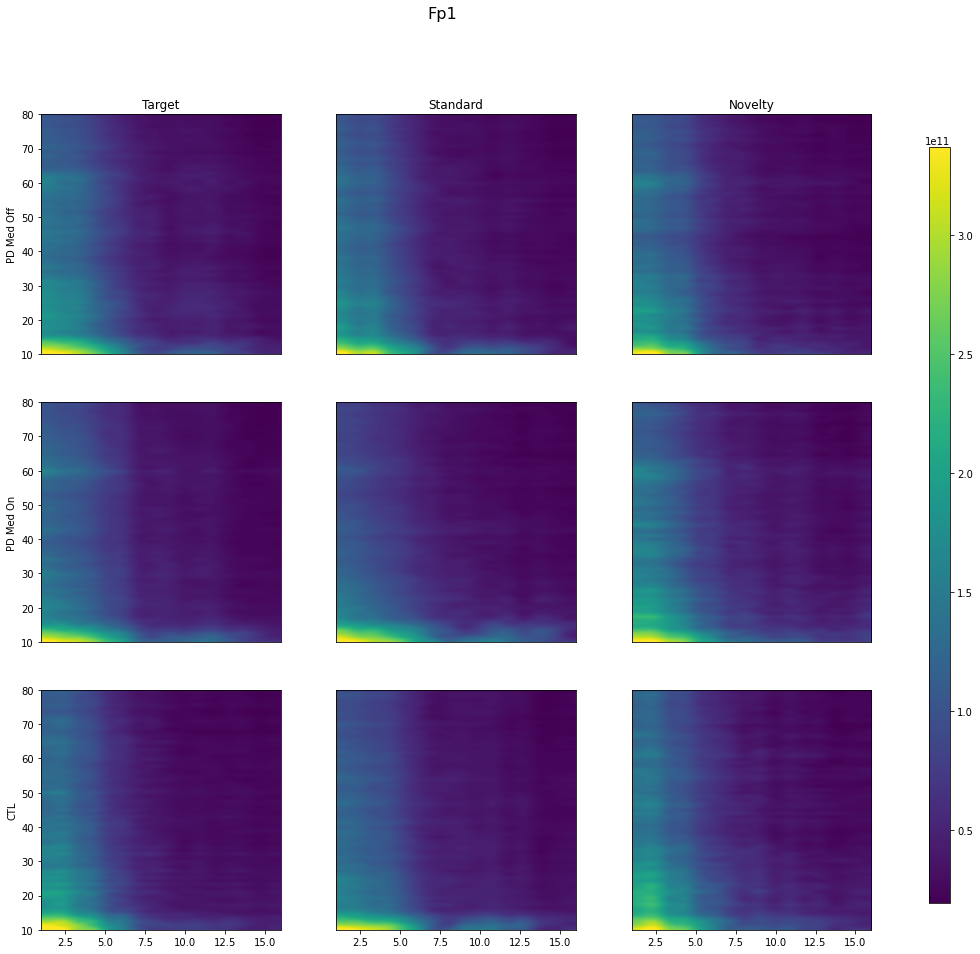

In [38]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
for ch in range(mvl_2ds.shape[3]):
    print(ch)
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for i, j in itertools.product(range(3), range(3)):
        im = plot_pac(mvl_2ds[i, :, j, ch].mean(axis=0), ax=axs[i, j],)
#                       vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'pac{suffix}', f'pac_{channels[ch]}{suffix}'))
#     plt.close(fig)

    plt.show()
    break

## conv

In [39]:
import scipy.signal as sig

with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
for ch in range(mvl_2ds.shape[3]):
    print(ch)
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for i, j in itertools.product(range(3), range(3)):
        plt_data = mvl_2ds[i, :, j, ch].mean(axis=0).copy()
        plt_data = sig.convolve2d(plt_data, filt_wind, boundary='symm', mode='same')
        im = plot_pac(plt_data, ax=axs[i, j],)
#                       vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'pac_conv{suffix}', f'pac_conv_{channels[ch]}{suffix}'))
    plt.close(fig)

#     plt.show()
#     break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


In [40]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
for ch in range(mvl_2ds.shape[3]):
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for i, j in itertools.product(range(3), range(3)):
        im = plot_pac(mvl_2ds[i, :, j, ch].mean(axis=0), ax=axs[i, j],)
#                       vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'pac{suffix}', f'pac_{channels[ch]}{suffix}'))
    plt.close(fig)

#     plt.show()

In [41]:
list(itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)))

[(((0, 1), 0), 0),
 (((0, 1), 0), 1),
 (((0, 1), 0), 2),
 (((0, 2), 1), 0),
 (((0, 2), 1), 1),
 (((0, 2), 1), 2),
 (((1, 2), 2), 0),
 (((1, 2), 2), 1),
 (((1, 2), 2), 2)]

## ttest

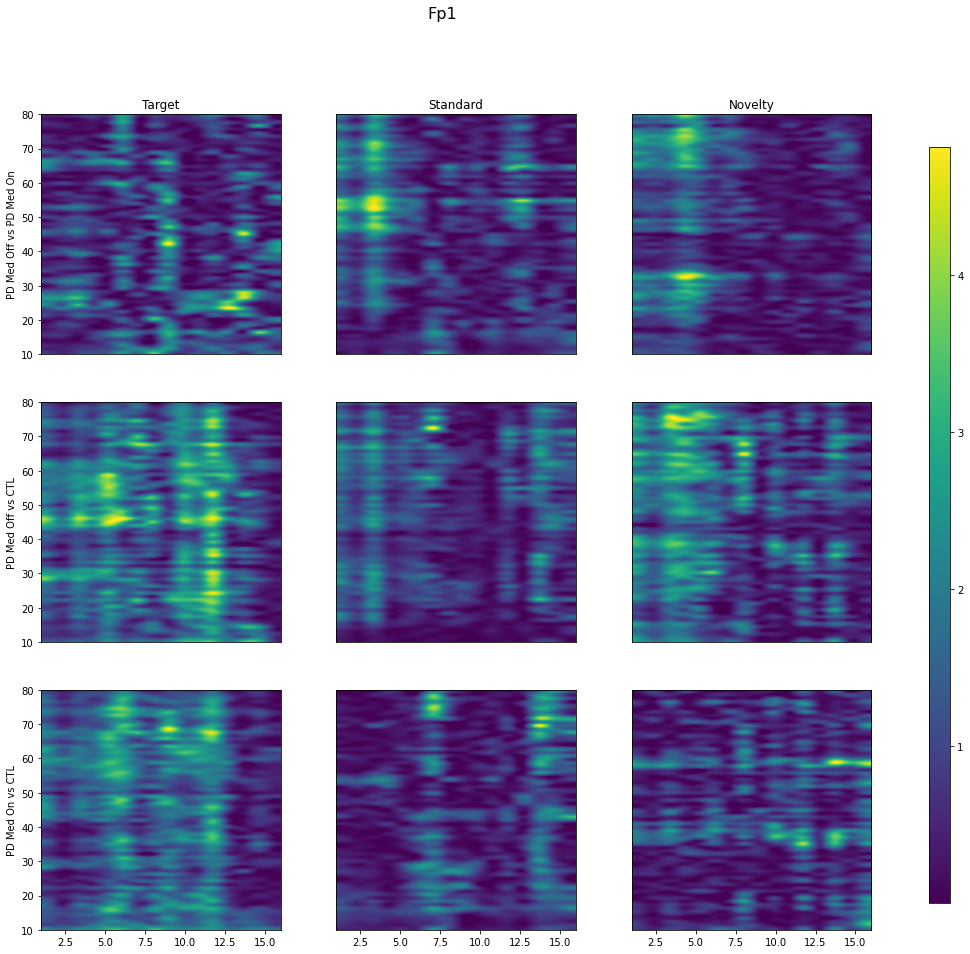

In [42]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
# --> (pd_drug_type, subjects, event_types, channels, high_freqs, low_freqs)
    
for ch in range(mvl_2ds.shape[3]):
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
        a, b = grp[0]
        i = grp[1]
        t, p = scipy.stats.ttest_ind(mvl_2ds[a, :, j, ch], mvl_2ds[b, :, j, ch])
#         p[p>0.05] = 1
        im = plot_pac(-np.log(p), ax=axs[i, j], )
#                       vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for grp in zip(itertools.combinations(range(3), 2), range(3)):
        a, b = grp[0]
        i = grp[1]
        
        axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'pac_pv{suffix}', f'pac_pv_{channels[ch]}{suffix}'))
#     plt.close(fig)

    plt.show()
    
    break

In [35]:
a = np.zeros((2, 2, 2))
b = a[:, 1, :].copy()
b[0, 0] = 10
a.sum()

0.0

In [ ]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
# --> (pd_drug_type, subjects, event_types, channels, high_freqs, low_freqs)
    
for ch in range(mvl_2ds.shape[3]):
    print(ch)
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
        a, b = grp[0]
        i = grp[1]
        test_data1, test_data2 = mvl_2ds[a, :, j, ch].copy(), mvl_2ds[b, :, j, ch].copy()
        for sub in range(mvl_2ds.shape[1]):
            test_data1[:, sub] = sig.convolve2d(test_data1[:, sub], 1/9 * np.ones((3, 3)), boundary='symm', mode='same')
            test_data2[:, sub] = sig.convolve2d(test_data2[:, sub], 1/9 * np.ones((3, 3)), boundary='symm', mode='same')
        t, p = scipy.stats.ttest_ind(test_data1, test_data2)
#         p[p>0.05] = 1
        im = plot_pac(-np.log(p), ax=axs[i, j], )
#                       vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for grp in zip(itertools.combinations(range(3), 2), range(3)):
        a, b = grp[0]
        i = grp[1]
        
        axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'pac_conv_pv{suffix}', f'pac_conv_pv_{channels[ch]}{suffix}'))
    plt.close(fig)

#     plt.show()
    
#     break

In [56]:
p.shape

(61, 13)

## Sum of $-log(p_v)$

In [44]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']

pv = np.zeros((mvl_2ds.shape[3], 3, 3, 71, 16))
    
for ch in range(mvl_2ds.shape[3]):
#     print(ch)
    for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
        a, b = grp[0]
        i = grp[1]
        test_data1, test_data2 = mvl_2ds[a, :, j, ch].copy(), mvl_2ds[b, :, j, ch].copy()
        for sub in range(mvl_2ds.shape[1]):
            test_data1[:, sub] = sig.convolve2d(test_data1[:, sub], filt_wind, boundary='symm', mode='same')
            test_data2[:, sub] = sig.convolve2d(test_data2[:, sub], filt_wind, boundary='symm', mode='same')
        
        t, p = scipy.stats.ttest_ind(test_data1, test_data2)
        p[p>0.05] = 1
        pv[ch, i, j]=(-np.log(p))
        
pv = np.array(pv)


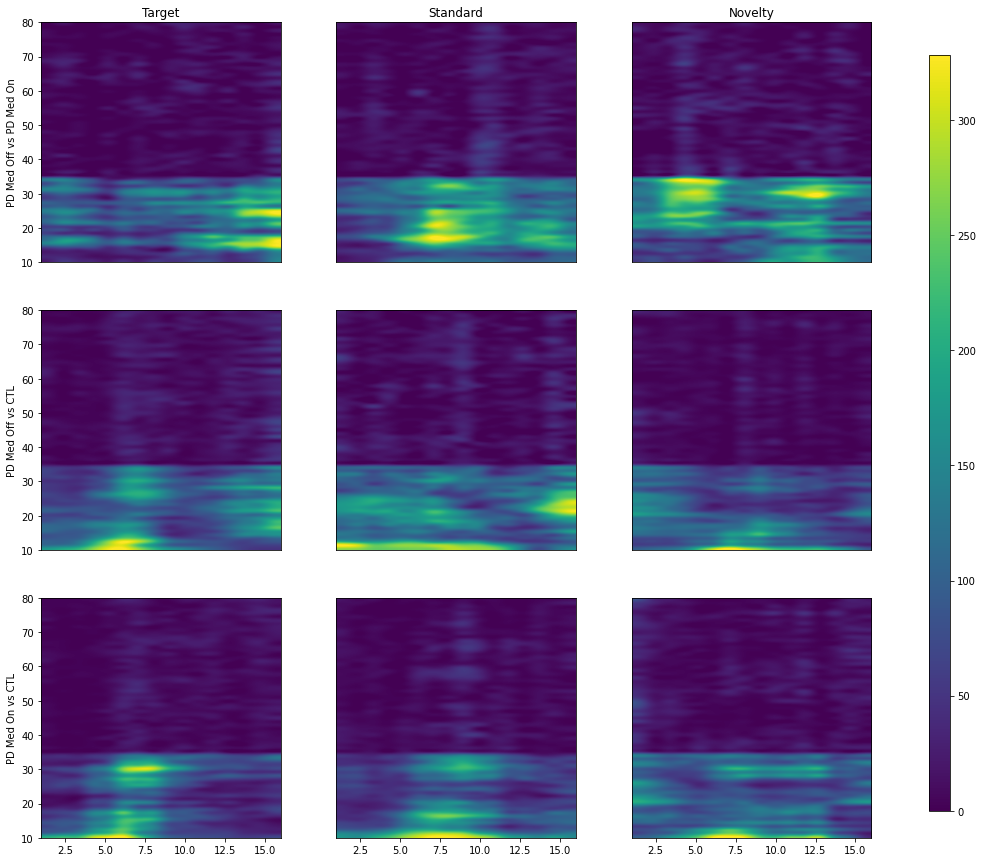

In [45]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
for i, j in itertools.product(range(3), range(3)):
    im = plot_pac(pv.sum(axis=0)[i, j], ax=axs[i, j],)
#                       vmin=vmin, vmax=vmax)
    axs[i, j].xaxis.set_visible(False)
    axs[i, j].yaxis.set_visible(False)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

for grp in zip(itertools.combinations(range(3), 2), range(3)):
    a, b = grp[0]
    i = grp[1]

    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)

# Plot Time PAC

In [130]:
mvl_2ds_time = [[] for k in groups] 

for task in tasks_df.iloc:
    task_mvl_2ds_time = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'mvl_2d_times{suffix}.npz')))
    
    # mvl_2ds
    mvl_2d_time = np.zeros((3, nbchan, gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1, len(range(-200, 1000 + 1, 200)) - 1))
    for i, event_type in enumerate(sorted(task_mvl_2ds_time.files)):
        mvl_2d_time[i] = task_mvl_2ds_time[event_type]
        
    mvl_2ds_time[task.pd_drug_type].append(mvl_2d_time)
        
mvl_2ds_time = np.array(mvl_2ds_time) #(3, 25, 3, 63, 61, 13, 12)
mvl_time = mvl_2ds_time
mvl_2ds_time = mvl_2ds_time.reshape(np.concatenate((np.array(mvl_2ds_time.shape[:-2]), [-1])))

In [131]:
def plot_time_pac(time_pac, high_freq=gamma, low_freq=beta, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((time_pac), origin='lower', interpolation='spline36', #'nearest', 
                   extent=[-200, 1000]+high_freq,
#                    aspect=1/(12/5),
#                    aspect=np.diff(low_freq)/np.diff(high_freq), 
                   **kwargs)

    if ax is None:
        plt.show()
        
    return im

In [ ]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
xticks = [-200]
for i in range(-100, 1001, 200):
    xticks += [7, 10, 13, i]
yticks = np.arange(20, 81, 20).tolist()

for ch in range(mvl_2ds_time.shape[3]):
    ch=61
    fig, axs = plt.subplots(9, 1, sharex=True, sharey=True, figsize=(10, 10))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for i, j in itertools.product(range(3), range(3)):
        ax = axs[3*i+ j]
        im = plot_time_pac(mvl_2ds_time[i, :, j, ch].mean(axis=0), ax=ax)
#                       vmin=vmin, vmax=vmax)
        
        ax.xaxis.set_major_locator(mticker.LinearLocator(len(range(-100, 1001, 200))))
        ax.xaxis.set_major_locator(mticker.LinearLocator(len(xticks)))
        ax.yaxis.set_major_locator(mticker.LinearLocator(len(yticks)))
        ax.set_xticklabels(xticks)
        ax.set_yticklabels(yticks)
        
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for i in range(3):
        axs[3*i].set_ylabel(groups[i])
        axs[ i].set_title(event_types[i])

        axs[6+ i].xaxis.set_visible(True)
        axs[3*i].yaxis.set_visible(True)
    fig.suptitle(f'{channels[ch]}', fontsize=16)

#     save_fig(os.path.join('plots', f'time_pac{suffix}', f'time_pac_{channels[ch]}{suffix}'))
#     plt.close(fig)

    plt.show()
    break

In [133]:
def plot_pac(pac, high_freq=gamma, low_freq=beta, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((pac), origin='lower', interpolation='spline36', #'nearest', 
                   extent=low_freq+high_freq,
#                    aspect='auto', )
                   aspect=np.diff(low_freq)/np.diff(high_freq), **kwargs)

    if ax is None:
        plt.show()
        
    return im

In [ ]:
mvl_time

for ch in range(mvl_2ds_time.shape[3]):
    ch=61
    fig, axs = plt.subplots(9, 6, sharex=False, sharey=True, figsize=(30, 30))
    plt.subplots_adjust(wspace = .05)
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for i, j, k in itertools.product(range(3), range(3), range(6)):
        ax = axs[i*3+j, k]
        im = plot_pac(mvl_time[i, :, j, ch, :, :, k].mean(axis=0), ax=ax)
#                       vmin=vmin, vmax=vmax)
        xticks = [-200 if k == 0 else '', 7, 10, 13, np.arange(-100, 1001, 200)[k]]
#         ax.xaxis.set_major_locator(mticker.LinearLocator(2))
        ax.xaxis.set_major_locator(mticker.LinearLocator(len(xticks)))
        ax.set_xticklabels(xticks)
#         ax.yaxis.set_major_locator(mticker.LinearLocator(len(yticks)))
#         ax.set_yticklabels(yticks)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for i in range(6):
        axs[-1, i].xaxis.set_visible(True)
#         axs[0, i].set_title(event_types[i])
    
    for i, j in itertools.product(range(3), range(3)):
        axs[3*i+j, 0].set_ylabel(f'{groups[i]}, {event_types[j]}')
        axs[3*i+j, 0].yaxis.set_visible(True)
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'time_pac{suffix}', f'time_pac_{channels[ch]}{suffix}'))
#     plt.close(fig)

    plt.show()
    break

In [ ]:
mvl_time

for ch in range(mvl_2ds_time.shape[3]):
    ch=61
    fig, axs = plt.subplots(9, 6, sharex=False, sharey=True, figsize=(30, 30))
    plt.subplots_adjust(wspace = .05)
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for i, j, k in itertools.product(range(3), range(3), range(6)):
        ax = axs[i*3+j, k]
        im = plot_pac(mvl_time[i, :, j, ch, :, :, k].mean(axis=0), ax=ax)
#                       vmin=vmin, vmax=vmax)
        xticks = [-200 if k == 0 else '', 7, 10, 13, np.arange(-100, 1001, 200)[k]]
#         ax.xaxis.set_major_locator(mticker.LinearLocator(2))
        ax.xaxis.set_major_locator(mticker.LinearLocator(len(xticks)))
        ax.set_xticklabels(xticks)
#         ax.yaxis.set_major_locator(mticker.LinearLocator(len(yticks)))
#         ax.set_yticklabels(yticks)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for i in range(6):
        axs[-1, i].xaxis.set_visible(True)
#         axs[0, i].set_title(event_types[i])
    
    for i, j in itertools.product(range(3), range(3)):
        axs[3*i+j, 0].set_ylabel(f'{groups[i]}, {event_types[j]}')
        axs[3*i+j, 0].yaxis.set_visible(True)
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'time_pac{suffix}', f'time_pac_{channels[ch]}{suffix}'))
#     plt.close(fig)

    plt.show()
    break
    
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
for ch in range(mvl_2ds.shape[3]):
    ch=61
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
    plt.subplots_adjust(wspace = .05)
    for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
        a, b = grp[0]
        i = grp[1]
        t, p = scipy.stats.ttest_ind(mvl_2ds[a, :, j, ch], mvl_2ds[b, :, j, ch])
        p[p>0.05] = 1
        im = plot_pac(-np.log(p), ax=axs[i, j], )
#                       vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for grp in zip(itertools.combinations(range(3), 2), range(3)):
        a, b = grp[0]
        i = grp[1]
        
        axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        
    fig.suptitle(f'{channels[ch]}', fontsize=16)

    save_fig(os.path.join('plots', f'time_pac_pv{suffix}', f'time_pac_pv_{channels[ch]}{suffix}'))
#     plt.close(fig)

    plt.show()
    break

# Plot topographic PAC

In [53]:
mvl_2ds_filt = mvl_2ds.copy()

for sub, ch in itertools.product(range(mvl_2ds.shape[1]), range(mvl_2ds.shape[3])):
    mvl_2ds_filt[i, sub, j, ch, :, :] = sig.convolve2d(mvl_2ds_filt[i, sub, j, ch, :, :],
                                                       filt_wind, boundary='symm', mode='same')

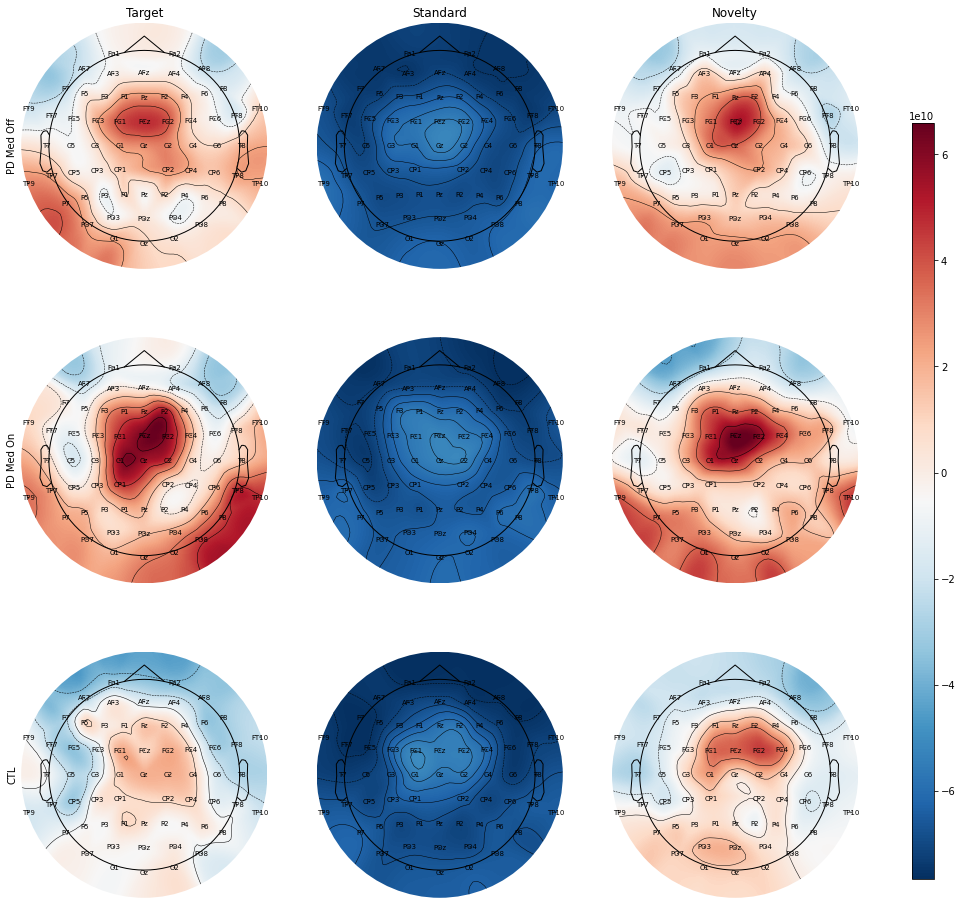

In [56]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
Xind = np.where(np.arange(*beta) == 7)[0][0]
Yind = np.where(np.arange(*gamma) == 30)[0][0]
    
if 'VEOG' in channels: channels.remove('VEOG')

# create_elc_file(task)
montage = mne.channels.read_custom_montage(os.path.join(
    task.dir, task.file_formatter.format('electrodes.elc')))

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
n_channels = mvls.shape[-1]
mne_info = mne.create_info(ch_names=channels, sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmin = mvl_2ds_filt[:, :, :, :, Yind, Xind].mean(axis=1).min()
vmax = mvl_2ds_filt[:, :, :, :, Yind, Xind].mean(axis=1).max()
for i, j in itertools.product(range(3), range(3)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    
    data = mvl_2ds_filt[i, :, j, :, Yind, Xind].mean(axis=0).reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0] - data.mean(), 
                                  mvl_evoked.info, axes=axs[i, j], show=False,
                                  names=channels, show_names=True, 
                                  vmin=vmin-data.mean(), vmax=vmax-data.mean())

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

# mne.viz.mne_analyze_colormap(limits=[vmin, (vmin+vmax)/2, vmax], format='mayavi')

plt.show()


In [49]:
np.where(np.arange(*beta) == 6)[0]

(array([5]),)

In [137]:
subjects = []
sub = [0] * 3
for task in tasks_df.iloc:
    subjects.append(sub[task.pd_drug_type])
    sub[task.pd_drug_type] += 1
    
tasks_df['subject'] = subjects

In [ ]:
fig, axs = plt.subplots(25, 3, sharex=True, sharey=False, figsize=(10, 50))

for task in tasks_df.iloc:
    
    data = mvl_2ds[task.pd_drug_type, task.subject, 0, :, 10, 2]
    axs[task.subject, task.pd_drug_type].plot(data)
#     axs[task.subject, task.pd_drug_type].set_title(f'{sub}')

plt.show()

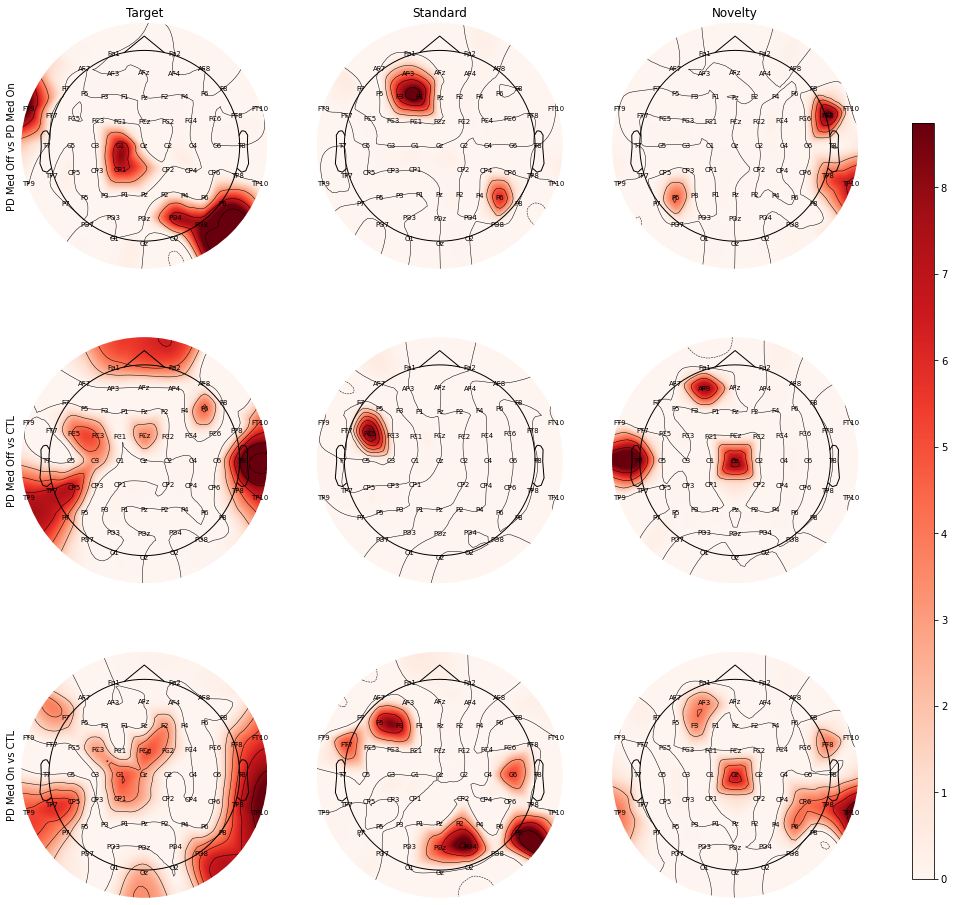

In [57]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
if 'VEOG' in channels: channels.remove('VEOG')

# create_elc_file(task)
montage = mne.channels.read_custom_montage(os.path.join(
    task.dir, task.file_formatter.format('electrodes.elc')))

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
n_channels = mvls.shape[-1]
mne_info = mne.create_info(ch_names=channels, sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
# vmin, vmax = mvls.mean(axis=1).min(), mvls.mean(axis=1).max() #get_percent(mvls.mean(axis=1), 0.95)
for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
    a, b = grp[0]
    i = grp[1]
    data_a = mvl_2ds_filt[a, :, j, :, Yind, Xind]
    data_b = mvl_2ds_filt[b, :, j, :, Yind, Xind]
    t, p = scipy.stats.ttest_ind(data_a, data_b)
    p[p>0.05] = 1
    p = p.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(-np.log(p) ,#- -np.log(p).mean(),
                                  mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0], 
                                  mvl_evoked.info, axes=axs[i, j], 
                                  show=False,
                                  names=channels, show_names=True)
    #, vmin=vmin- mvls.mean(), vmax=vmax- mvls.mean())

for grp in zip(itertools.combinations(range(3), 2), range(3)):
    a, b = grp[0]
    i = grp[1]

    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)

# mne.viz.mne_analyze_colormap(limits=[vmin, (vmin+vmax)/2, vmax], format='mayavi')


plt.show()

In [140]:

t, p = scipy.stats.ttest_ind(data_a, data_b)
data_a.shape, data_b.shape, p.shape
#     p[p>0.05] = 1


((25, 63), (25, 63), (63,))

In [141]:
# mvl_2ds[a, :, j, :, :, :].shape
np.array(list(itertools.product(range(20, 81), range(6, 17))))

array([[20,  6],
       [20,  7],
       [20,  8],
       ...,
       [80, 14],
       [80, 15],
       [80, 16]])

# Plot topographic Time PAC

/usr/local/share/.virtualenvs/sci/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


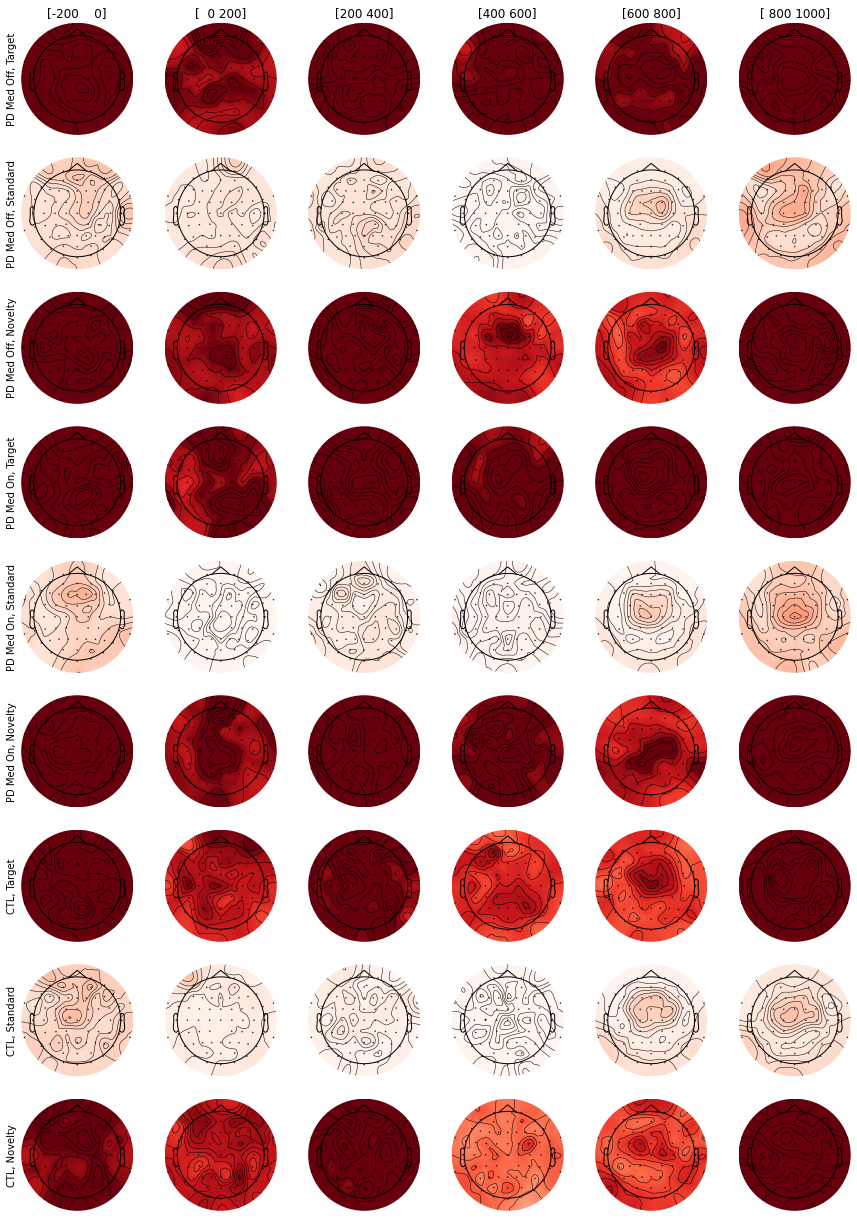

In [142]:
mvl_time

with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
if 'VEOG' in channels: channels.remove('VEOG')

# create_elc_file(task)
montage = mne.channels.read_custom_montage(os.path.join(
    task.dir, task.file_formatter.format('electrodes.elc')))

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
n_channels = mvls.shape[-1]
mne_info = mne.create_info(ch_names=channels, sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(9, 6, sharex=True, sharey=True, figsize=(15, 20))
vmin = mvl_time[i, :, j, :, 10, 2, :].mean(axis=0).min()
vmax = mvl_time[i, :, j, :, 10, 2, :].mean(axis=0).max()
for i, j, k in itertools.product(range(3), range(3), range(6)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    data = mvl_time[i, :, j, :, 10, 2, k].mean(axis=0).reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data, mne_info)
    mvl_evoked.set_montage(montage)
    mne.viz.plot_topomap(mvl_evoked.data[:, 0],# - data.mean(), 
                         mvl_evoked.info, axes=axs[i*3+j, k], show=False,
                         names=channels, show_names=False, vmin=vmin-data.mean(), vmax=vmax-data.mean())
    

for i in range(6):
    axs[0, i].set_title(np.arange(-200, 1001, 200)[i:i+2])
    
for i, j in itertools.product(range(3), range(3)):
    axs[i*3+j, 0].set_ylabel(f'{groups[i]}, {event_types[j]}')
    axs[i*3+j, 0].yaxis.set_visible(True)
        
# mne.viz.mne_analyze_colormap(limits=[vmin, (vmin+vmax)/2, vmax], format='mayavi')

plt.show()

# Tests

In [ ]:
[
    epochs.shape,
    mvls.shape, 
    mvl_2ds.shape, 
    mvl_time.shape,
    mvl_2ds_time.shape
]

In [ ]:
os.path.join(task['dir'], task['file_formatter'].format(f'epochs.npz'))

In [ ]:
np.savez_compressed('/home/kiani/DS/ds003490-download/extracted_data/mvls30_6.npz',
                    epochs=mvl_2ds[:, :, :, :, 10, 2])

In [ ]:
mvl_2ds[:, :, :, :, 10, 2]